In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 设置字体大小
plt.rcParams['font.size'] = 20


In [3]:
data_path = r'..\Question\Wimbledon_featured_matches.csv'
data = pd.read_csv(data_path)
print(data.head())

              match_id         player1        player2 elapsed_time  set_no  \
0  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:00:00       1   
1  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:00:38       1   
2  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:01:01       1   
3  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:01:31       1   
4  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:02:21       1   

   game_no  point_no  p1_sets  p2_sets  p1_games  ...  p2_break_pt_won  \
0        1         1        0        0         0  ...                0   
1        1         2        0        0         0  ...                0   
2        1         3        0        0         0  ...                0   
3        1         4        0        0         0  ...                0   
4        1         5        0        0         0  ...                0   

  p1_break_pt_missed p2_break_pt_missed  p1_distance_run  p2_distance_run  \
0        

In [181]:
# 按match_id分组
grouped = data.groupby('match_id')
print(grouped.size())

match_id
2023-wimbledon-1301    300
2023-wimbledon-1302    201
2023-wimbledon-1303    134
2023-wimbledon-1304    337
2023-wimbledon-1305    246
2023-wimbledon-1306    332
2023-wimbledon-1307    232
2023-wimbledon-1308    190
2023-wimbledon-1309    213
2023-wimbledon-1310    318
2023-wimbledon-1311    170
2023-wimbledon-1312    275
2023-wimbledon-1313    290
2023-wimbledon-1314    185
2023-wimbledon-1315    198
2023-wimbledon-1316    167
2023-wimbledon-1401    225
2023-wimbledon-1402    274
2023-wimbledon-1403    122
2023-wimbledon-1404    286
2023-wimbledon-1405    215
2023-wimbledon-1406    195
2023-wimbledon-1407    331
2023-wimbledon-1408    271
2023-wimbledon-1501    189
2023-wimbledon-1502    283
2023-wimbledon-1503    193
2023-wimbledon-1504    217
2023-wimbledon-1601    159
2023-wimbledon-1602    202
2023-wimbledon-1701    334
dtype: int64


In [182]:
sample_match = grouped.get_group('2023-wimbledon-1301')
print(sample_match)

                match_id         player1        player2 elapsed_time  set_no  \
0    2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:00:00       1   
1    2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:00:38       1   
2    2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:01:01       1   
3    2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:01:31       1   
4    2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:02:21       1   
..                   ...             ...            ...          ...     ...   
295  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     03:53:25       4   
296  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     03:54:01       4   
297  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     03:55:02       4   
298  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     03:55:34       4   
299  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     03:56:11       4   

     game_no  point_no  p1_sets  p2_set

In [183]:
def analyse_match(match):
    match_id = match['match_id']
    player1 = match['player1']
    player2 = match['player2']
    # point_victor,winner of the point,"1 if player 1 wins, 2 if player 2 wins"
    # 统计单盘比赛中每个球员的得分情况
    set_grouped = match.groupby('set_no')
    res_dict = {'player1_score':[], 'player2_score':[], 
                'player1_win_double_count':[], 'player2_win_double_count':[], 'player1_loss_after_win':[], 'player2_loss_after_win':[],
                'player1_win_with_serve':[], 'player2_win_with_serve':[], 'player1_loss_with_serve':[], 'player2_loss_with_serve':[],
                'player1_win_double_count_with_serve':[], 'player2_win_double_count_with_serve':[], 'player1_loss_after_win_with_serve':[], 'player2_loss_after_win_with_serve':[],
                'player1_win_double_count_with_return':[], 'player2_win_double_count_with_return':[], 'player1_loss_after_win_with_return':[], 'player2_loss_after_win_with_return':[]
                }
    for set_no, set_data in set_grouped:
        player1_score = 0
        player2_score = 0
        # 统计 player 连赢两盘的次数
        player1_win_double_count = 0
        player2_win_double_count = 0
        # 统计 player 连赢一盘后输掉下一盘的次数\
        player1_loss_after_win = 0
        player2_loss_after_win = 0
        # 统计 player 赢得发球局的次数
        player1_win_with_serve = 0
        player2_win_with_serve = 0
        # 统计 player 输掉接发局的次数
        player1_loss_with_serve = 0
        player2_loss_with_serve = 0
        # 统计 player 赢得发球局且连赢两次的次数
        player1_win_double_count_with_serve = 0
        player2_win_double_count_with_serve = 0
        player1_loss_after_win_with_serve = 0
        player2_loss_after_win_with_serve = 0
        # 统计 player 输掉接发局且连赢两次的次数
        player1_win_double_count_with_return = 0
        player2_win_double_count_with_return = 0
        player1_loss_after_win_with_return = 0
        player2_loss_after_win_with_return = 0

        flag = -1
        pre_game_no = 0
        for index, row in set_data.iterrows():
            point_victor = row['point_victor']
            serve_flag = row['server']
            if point_victor == 1:
                player1_score += 1
                player1_win_double_count += (flag == 1)
                player2_loss_after_win += (flag == 2)
                if serve_flag == 1:
                    player1_win_with_serve += 1
                    player1_win_double_count_with_serve += (flag == 1)
                    player2_loss_after_win_with_return += (flag == 2)
                else:
                    player2_loss_with_serve += 1
                    player1_win_double_count_with_return += (flag == 1)
                    player2_loss_after_win_with_serve += (flag == 2)
            else:
                player2_score += 1
                player2_win_double_count += (flag == 2)
                player1_loss_after_win += (flag == 1)
                if serve_flag == 2:
                    player2_win_with_serve += 1
                    player2_win_double_count_with_serve += (flag == 2)
                    player1_loss_after_win_with_return += (flag == 1)
                else:
                    player1_loss_with_serve += 1
                    player2_win_double_count_with_return += (flag == 2)
                    player1_loss_after_win_with_serve += (flag == 1)
            flag = point_victor
            # 检测是否是新的局
            game_no = row['game_no']
            if game_no != pre_game_no:
                flag = -1
                pre_game_no = game_no

        res_dict['player1_score'].append(player1_score)
        res_dict['player2_score'].append(player2_score)
        res_dict['player1_win_double_count'].append(player1_win_double_count)
        res_dict['player2_win_double_count'].append(player2_win_double_count)
        res_dict['player1_loss_after_win'].append(player1_loss_after_win)
        res_dict['player2_loss_after_win'].append(player2_loss_after_win)
        res_dict['player1_win_with_serve'].append(player1_win_with_serve)
        res_dict['player2_win_with_serve'].append(player2_win_with_serve)
        res_dict['player1_loss_with_serve'].append(player1_loss_with_serve)
        res_dict['player2_loss_with_serve'].append(player2_loss_with_serve)
        res_dict['player1_win_double_count_with_serve'].append(player1_win_double_count_with_serve)
        res_dict['player2_win_double_count_with_serve'].append(player2_win_double_count_with_serve)
        res_dict['player1_loss_after_win_with_serve'].append(player1_loss_after_win_with_serve)
        res_dict['player2_loss_after_win_with_serve'].append(player2_loss_after_win_with_serve)
        res_dict['player1_win_double_count_with_return'].append(player1_win_double_count_with_return)
        res_dict['player2_win_double_count_with_return'].append(player2_win_double_count_with_return)
        res_dict['player1_loss_after_win_with_return'].append(player1_loss_after_win_with_return)
        res_dict['player2_loss_after_win_with_return'].append(player2_loss_after_win_with_return)
        
    # print(res_dict)
    return res_dict
res_dict = analyse_match(sample_match)

In [184]:
# 卡方检验Momentum
def chi_square_test_momentum(res_dict):
    player_win_after_loss = res_dict['player1_loss_after_win'] + res_dict['player2_loss_after_win']
    player_loss_after_loss =  res_dict['player1_win_double_count'] + res_dict['player2_win_double_count']
    player_win_double_count = res_dict['player1_win_double_count'] + res_dict['player2_win_double_count']
    player_loss_after_win = res_dict['player1_loss_after_win'] + res_dict['player2_loss_after_win']
    # print(player1_score)

    # 卡方检验
    a = sum(player_win_after_loss) 
    b = sum(player_win_double_count)
    c = sum(player_loss_after_loss)
    d = sum(player_loss_after_win)
    chi_square_score = (a*d-b*c)**2*(a+b+c+d)/(a+b)/(c+d)/(a+c)/(b+d)
    # print(chi_square_score)
    return chi_square_score

# 卡方检验发球优势
def chi_square_test_serve(res_dict):
    # player_score = res_dict['player1_score'] + res_dict['player2_score']
    # player_loss = res_dict['player2_score'] + res_dict['player1_score']
    player_win_with_return = res_dict['player1_loss_with_serve'] + res_dict['player2_loss_with_serve']
    player_loss_with_return = res_dict['player1_win_with_serve'] + res_dict['player2_win_with_serve']
    
    player_win_with_serve = res_dict['player1_win_with_serve'] + res_dict['player2_win_with_serve']
    player_loss_with_serve = res_dict['player1_loss_with_serve'] + res_dict['player2_loss_with_serve']
    # print(player1_score)

    # 卡方检验
    a = sum(player_win_with_return)
    b = sum(player_win_with_serve)
    c = sum(player_loss_with_return)
    d = sum(player_loss_with_serve)
    chi_square_score = (a*d-b*c)**2*(a+b+c+d)/(a+b)/(c+d)/(a+c)/(b+d)
    # print(chi_square_score)
    return chi_square_score

# remove 发球优势对检验momentum的影响
def chi_square_test_momentum_without_serve(res_dict):
    player_win_after_loss_with_serve = res_dict['player1_loss_after_win_with_return'] + res_dict['player2_loss_after_win_with_return']
    player_loss_after_loss_with_serve = res_dict['player1_win_double_count_with_return'] + res_dict['player2_win_double_count_with_return']
    player_win_double_count_with_serve = res_dict['player1_win_double_count_with_serve'] + res_dict['player2_win_double_count_with_serve']
    player_loss_after_win_with_serve = res_dict['player1_loss_after_win_with_serve'] + res_dict['player2_loss_after_win_with_serve']
    # print(player1_score)

    # 卡方检验
    a = sum(player_win_after_loss_with_serve)
    b = sum(player_win_double_count_with_serve)
    c = sum(player_loss_after_loss_with_serve)
    d = sum(player_loss_after_win_with_serve)
    
    chi_square_score = (a*d-b*c)**2*(a+b+c+d)/(a+b)/(c+d)/(a+c)/(b+d)
    # print(chi_square_score)
    return chi_square_score

In [185]:
# 检验 momentum
# 穷举所有的比赛
chi_square_score_list = []
ratio_of_score_with_momentum = []
for match_id, match in grouped:
    res_dict = analyse_match(match)
    chi_square_score = chi_square_test_momentum(res_dict)
    chi_square_score_list.append(chi_square_score)
    ratio_of_score_with_momentum.append(
        (sum(res_dict['player1_win_double_count']) + sum(res_dict['player2_win_double_count'])) /
        sum(res_dict['player1_loss_after_win']+res_dict['player1_win_double_count'] + res_dict['player2_loss_after_win']+res_dict['player2_win_double_count'])
    )
print(chi_square_score_list)
# 穷举所有比赛的结果求和
match_all = {'player1_score':[], 'player2_score':[], 'player1_win_double_count':[], 'player2_win_double_count':[], 'player1_loss_after_win':[], 'player2_loss_after_win':[]}
for match_id, match in grouped:
    res_dict = analyse_match(match)
    for key in match_all.keys():
        match_all[key].extend(res_dict[key])
print(match_all)
chi_square_score_all = chi_square_test_momentum(match_all)
print(chi_square_score_all)


[0.007905138339920948, 0.9938650306748467, 2.7169811320754715, 0.8612099644128114, 0.24630541871921183, 3.5588235294117645, 7.11578947368421, 4.207792207792208, 0.5664739884393064, 8.281368821292777, 7.0144927536231885, 1.4759825327510918, 0.205761316872428, 1.894736842105263, 4.0, 0.014814814814814815, 0.8756756756756757, 0.035398230088495575, 0.3137254901960784, 0.5565217391304348, 4.444444444444445, 10.713375796178344, 5.4200743494423795, 20.17351598173516, 2.9411764705882355, 1.4632034632034632, 11.688311688311689, 0.2824858757062147, 3.488372093023256, 0.10778443113772455, 0.17667844522968199]
{'player1_score': [34, 44, 34, 46, 22, 34, 43, 20, 18, 13, 26, 34, 32, 29, 48, 27, 32, 34, 36, 29, 36, 36, 47, 28, 41, 36, 46, 26, 42, 22, 25, 27, 24, 39, 34, 41, 39, 23, 26, 34, 25, 8, 36, 32, 41, 38, 32, 44, 49, 30, 34, 28, 45, 38, 27, 27, 20, 13, 37, 27, 31, 35, 29, 40, 37, 37, 20, 34, 36, 19, 36, 16, 30, 36, 44, 45, 31, 21, 33, 29, 27, 39, 31, 39, 34, 30, 35, 39, 34, 21, 45, 27, 31, 36, 

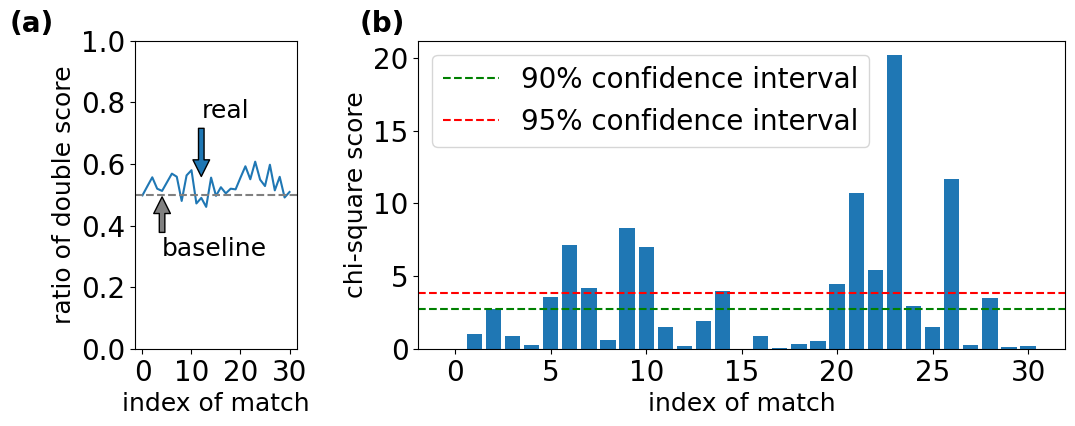

In [186]:
# 可视化 momentum kappa
fondsize = 20
fig, axes = plt.subplots(1, 2, figsize=(12, 4), width_ratios=[1, 4])
# 两个子图间加间距
plt.subplots_adjust(wspace=0.3)

# 堆叠箱线图，显示每局比赛中先发优势的分布情况
ax = axes[0]
ax.plot(ratio_of_score_with_momentum)
# 添加箭头和文字 real, 字体大小
ax.annotate('real', xy=(12, 0.55), xytext=(12, 0.75),
            arrowprops=dict( shrink=0.05),
            fontsize=fondsize-2
            )
ax.axhline(y=0.5, color='grey', linestyle='--', label='50%')
# 添加箭头和文字 baseline, 字体大小
ax.annotate('baseline', xy=(4, 0.5), xytext=(4, 0.3),
            arrowprops=dict(facecolor='grey', shrink=0.05),
            fontsize=fondsize-2
            )

ax.set_xlabel('index of match', fontsize=fondsize-2)
ax.set_ylabel('ratio of double score', fontsize=fondsize-2)
# plt.title('Ratio of score with serve', fontsize=fondsize)
ax.set_xticks(np.arange(0, 31, 10))
ax.set_yticks(np.arange(0, 1.1, 0.2))
# 图左上标号（a）
ax.text(-0.5, 1.1, '(a)', transform=ax.transAxes, fontsize=fondsize, weight='bold', va='top', ha='right')

ax = axes[1]
ax.bar(np.arange(len(chi_square_score_list)), chi_square_score_list)
ax.set_xlabel('index of match', fontsize=fondsize-2)
ax.set_ylabel('chi-square score', fontsize=fondsize-2)
# plt.title('Chi-square score of serve advantage', fontsize=fondsize)
# 置信度
ax.axhline(y=2.706, color='g', linestyle='--', label='90% confidence interval')
ax.axhline(y=3.841, color='r', linestyle='--', label='95% confidence interval')
# ax.axhline(y=6.635, color='g', linestyle='--', label='99% confidence interval')
# ax.axhline(y=10.827, color='r', linestyle='--', label='99.9% confidence interval')
ax.legend()
# 图左上标号（b）
ax.text(-0.02, 1.1, '(b)', transform=ax.transAxes, fontsize=fondsize, weight='bold', va='top', ha='right')
save_path = r'C:\Users\cheng\Desktop\20240201\Latex\figures\serve_advantage_kappa.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.savefig(save_path.replace('.png', '.svg'), bbox_inches='tight', dpi=300)
plt.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', dpi=300)
plt.show()



In [187]:
# 检验发球优势
chi_square_score_list = []
ratio_of_score_with_serve = []
for match_id, match in grouped:
    res_dict = analyse_match(match)
    ratio_of_score_with_serve.append((sum(res_dict['player1_win_with_serve'])+sum(res_dict['player2_win_with_serve']))/(sum(res_dict['player1_score'])+sum(res_dict['player2_score'])))
    chi_square_score = chi_square_test_serve(res_dict)
    chi_square_score_list.append(chi_square_score)
print(chi_square_score_list)
# 穷举所有比赛的结果求和
match_all = {'player1_score':[], 'player2_score':[], 'player1_win_with_serve':[], 'player2_win_with_serve':[], 'player1_loss_with_serve':[], 'player2_loss_with_serve':[]}
for match_id, match in grouped:
    res_dict_all = analyse_match(match)
    for key in match_all.keys():
        match_all[key].extend(res_dict_all[key])
print(match_all)
chi_square_score_all = chi_square_test_serve(match_all)
print(chi_square_score_all)


[54.0, 109.70149253731343, 37.3134328358209, 70.51038575667656, 49.46341463414634, 114.72289156626506, 108.13793103448276, 77.85263157894737, 47.333333333333336, 14.49056603773585, 31.811764705882354, 13.447272727272727, 37.765517241379314, 45.67567567567568, 58.343434343434346, 47.532934131736525, 47.36888888888889, 91.56204379562044, 16.78688524590164, 87.72027972027972, 52.325581395348834, 43.333333333333336, 145.16616314199396, 146.72324723247232, 66.04232804232804, 74.97526501766785, 38.55958549222798, 46.46082949308756, 15.40880503144654, 54.21782178217822, 32.790419161676645]
{'player1_score': [34, 44, 34, 46, 22, 34, 43, 20, 18, 13, 26, 34, 32, 29, 48, 27, 32, 34, 36, 29, 36, 36, 47, 28, 41, 36, 46, 26, 42, 22, 25, 27, 24, 39, 34, 41, 39, 23, 26, 34, 25, 8, 36, 32, 41, 38, 32, 44, 49, 30, 34, 28, 45, 38, 27, 27, 20, 13, 37, 27, 31, 35, 29, 40, 37, 37, 20, 34, 36, 19, 36, 16, 30, 36, 44, 45, 31, 21, 33, 29, 27, 39, 31, 39, 34, 30, 35, 39, 34, 21, 45, 27, 31, 36, 16, 23, 42, 33, 

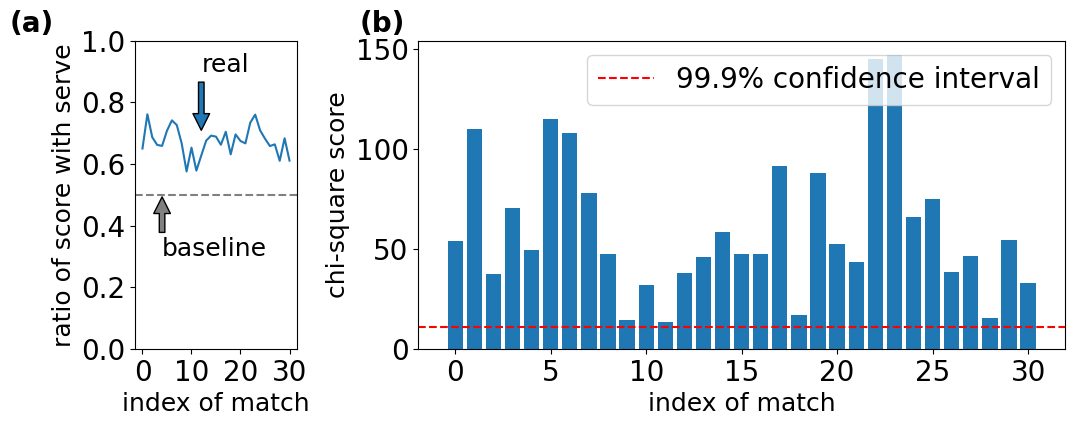

In [188]:
# 可视化发球优势kappa
fondsize = 20
fig, axes = plt.subplots(1, 2, figsize=(12, 4), width_ratios=[1, 4])
# 两个子图间加间距
plt.subplots_adjust(wspace=0.3)

# 堆叠箱线图，显示每局比赛中先发优势的分布情况
ax = axes[0]
ax.plot(ratio_of_score_with_serve)
# 添加箭头和文字 real, 字体大小
ax.annotate('real', xy=(12, 0.7), xytext=(12, 0.9),
            arrowprops=dict( shrink=0.05),
            fontsize=fondsize-2
            )
ax.axhline(y=0.5, color='grey', linestyle='--', label='50%')
# 添加箭头和文字 baseline, 字体大小
ax.annotate('baseline', xy=(4, 0.5), xytext=(4, 0.3),
            arrowprops=dict(facecolor='grey', shrink=0.05),
            fontsize=fondsize-2
            )

ax.set_xlabel('index of match', fontsize=fondsize-2)
ax.set_ylabel('ratio of score with serve', fontsize=fondsize-2)
# plt.title('Ratio of score with serve', fontsize=fondsize)
ax.set_xticks(np.arange(0, 31, 10))
ax.set_yticks(np.arange(0, 1.1, 0.2))
# 图左上标号（a）
ax.text(-0.5, 1.1, '(a)', transform=ax.transAxes, fontsize=fondsize, weight='bold', va='top', ha='right')

ax = axes[1]
ax.bar(np.arange(len(chi_square_score_list)), chi_square_score_list)
ax.set_xlabel('index of match', fontsize=fondsize-2)
ax.set_ylabel('chi-square score', fontsize=fondsize-2)
# plt.title('Chi-square score of serve advantage', fontsize=fondsize)
# 置信度
# ax.axhline(y=3.841, color='r', linestyle='--', label='95% confidence interval')
# ax.axhline(y=6.635, color='g', linestyle='--', label='99% confidence interval')
ax.axhline(y=10.827, color='r', linestyle='--', label='99.9% confidence interval')
ax.legend()
# 图左上标号（b）
ax.text(-0.02, 1.1, '(b)', transform=ax.transAxes, fontsize=fondsize, weight='bold', va='top', ha='right')
save_path = r'C:\Users\cheng\Desktop\20240201\Latex\figures\serve_advantage_kappa.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.savefig(save_path.replace('.png', '.svg'), bbox_inches='tight', dpi=300)
plt.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight', dpi=300)
plt.show()



In [192]:
# remove 发球优势对检验momentum的影响
chi_square_score_list = []
for match_id, match in grouped:
    res_dict = analyse_match(match)
    chi_square_score = chi_square_test_momentum_without_serve(res_dict)
    chi_square_score_list.append(chi_square_score)
print(chi_square_score_list)
# 穷举所有比赛的结果求和
# def chi_square_test_momentum_without_serve(res_dict):
    # player_win_after_loss_with_serve = res_dict['player1_loss_after_win_with_return'] + res_dict['player2_loss_after_win_with_return']
    # player_loss_after_loss_with_serve = res_dict['player1_win_double_count_with_return'] + res_dict['player2_win_double_count_with_return']
    # player_win_double_count_with_serve = res_dict['player1_win_double_count_with_serve'] + res_dict['player2_win_double_count_with_serve']
    # player_loss_after_win_with_serve = res_dict['player1_loss_after_win_with_serve'] + res_dict['player2_loss_after_win_with_serve']

match_all = {'player1_loss_after_win_with_return':[], 'player2_loss_after_win_with_return':[], 'player1_win_double_count_with_return':[], 'player2_win_double_count_with_return':[], 'player1_loss_after_win_with_serve':[], 'player2_loss_after_win_with_serve':[], 'player1_win_double_count_with_serve':[], 'player2_win_double_count_with_serve':[]}
for match_id, match in grouped:
    res_dict = analyse_match(match)
    for key in match_all.keys():
        match_all[key].extend(res_dict[key])
print(match_all)
chi_square_score_all = chi_square_test_momentum_without_serve(match_all)
print(chi_square_score_all)


[0.04272045028142589, 4.700793078586879e-05, 0.42738858089135295, 0.017184955918098547, 5.43585650761247e-05, 0.2803011324846851, 2.0549643268075957, 1.2833902559527195, 0.9674329773466421, 3.888012095865337, 2.539176570458404, 0.7390683337347946, 0.40660983106632537, 1.7054665242165243, 1.1007343930910816, 0.059340659340659345, 0.1087448817749571, 0.12245985939239407, 0.016859286424503815, 0.010266099704717204, 1.3128541686773563, 3.807083258010575, 0.6334206629587625, 5.720366117980311, 0.5618390129259694, 0.08117258622793222, 4.98987133680342, 0.000748761371020143, 1.3995996771589991, 0.4128334529686653, 0.013861395787321715]
{'player1_loss_after_win_with_return': [8, 10, 8, 14, 9, 12, 10, 4, 5, 3, 8, 5, 6, 8, 15, 5, 5, 7, 9, 7, 7, 10, 14, 8, 10, 8, 13, 9, 14, 5, 8, 7, 4, 11, 6, 4, 8, 4, 4, 8, 8, 3, 9, 8, 4, 7, 8, 13, 10, 4, 8, 7, 17, 10, 6, 7, 5, 3, 12, 10, 5, 7, 7, 8, 11, 10, 6, 9, 10, 7, 11, 4, 7, 8, 7, 15, 8, 5, 4, 6, 7, 8, 5, 11, 8, 7, 9, 9, 7, 3, 12, 5, 8, 8, 5, 8, 12, 6, 4, 5